# Retail Price Prediction for Cars

# 1. Data Preprocessing

## 1.1 Load and Inspect the Dataset

In [247]:
import pandas as pd

data = pd.read_csv('data.csv' )
print(data.head())

  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High-Performance      Compact         C

## 1.2 Handle Missing Values

In [248]:
# Check for missing values
print(data.isnull().sum())

# Fill missing numerical values with the median
numerical_features = ['Engine HP', 'Engine Cylinders', 'Number of Doors']
for col in numerical_features:
    data[col].fillna(data[col].median(), inplace=True)

# Fill missing categorical values with the mode
categorical_features = ['Engine Fuel Type', 'Market Category']
for col in categorical_features:
    data[col].fillna(data[col].mode()[0], inplace=True)


Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


## 1.3 Remove Duplicates

In [249]:
# Remove duplicates
data = data.drop_duplicates()


## 1.4 Scale the Target Variable 

In [250]:
# Scale MSRP if necessary
data['MSRP'] = data['MSRP'] / 10000  # Scale by 10,000


# 2. Exploratory Data Analysis (EDA)

## 2.1 Univariate Analysis:

<Axes: ylabel='Frequency'>

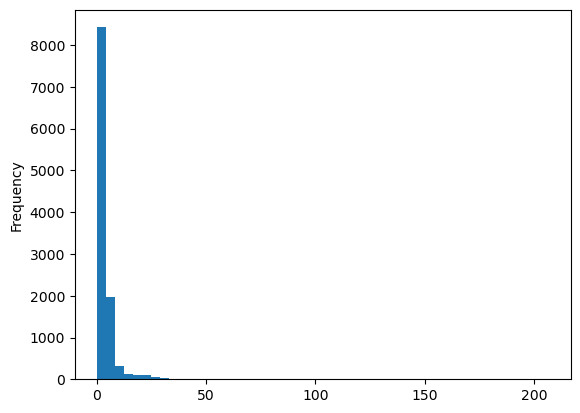

In [251]:
# Visualize MSRP distributions using histograms or KDE plots.(Identify skewness and kurtosis.)
data['MSRP'].plot(kind='hist', bins=50)


<Axes: xlabel='Make'>

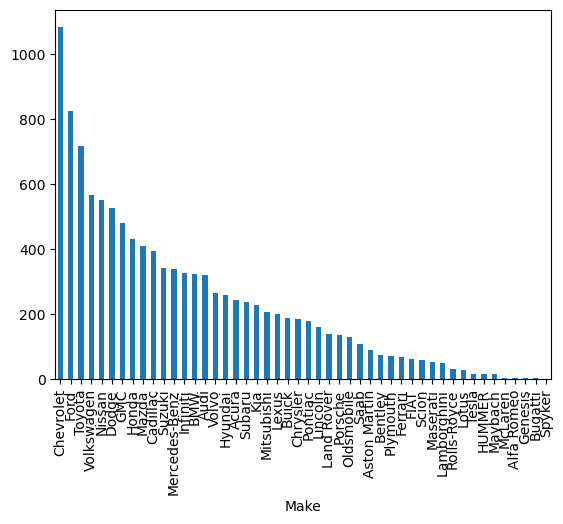

In [252]:
# Count the frequency of each category
data['Make'].value_counts().plot(kind='bar')


## 2.2 Bivariate Analysis:

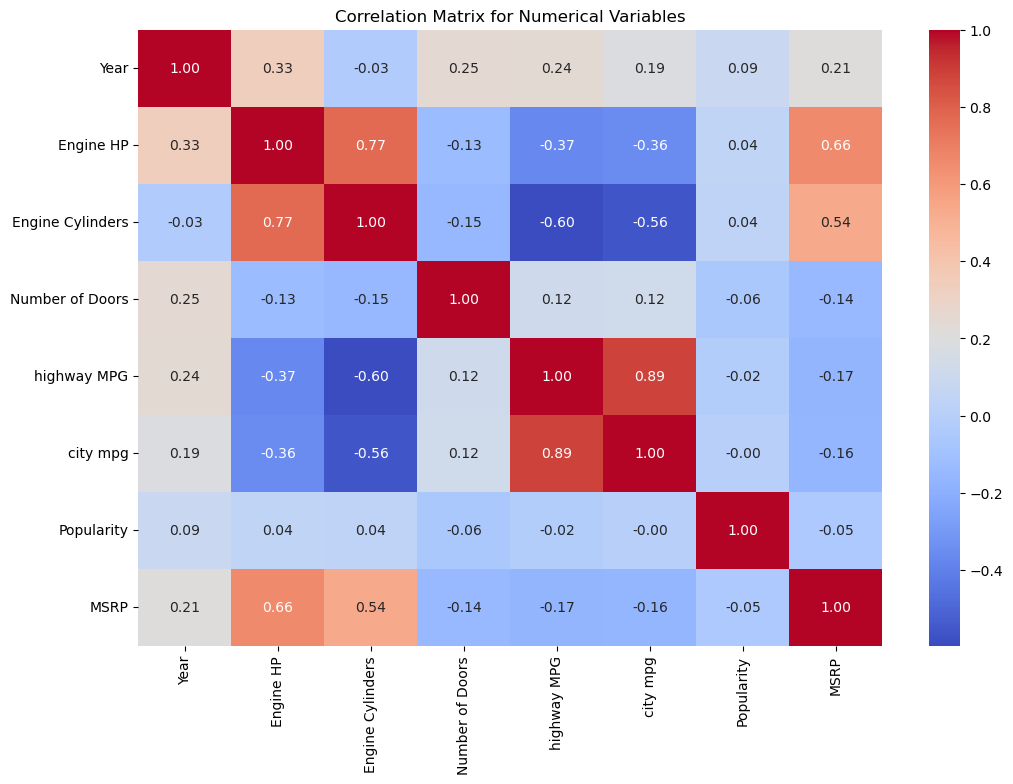

In [253]:
import seaborn as sns

# Compute correlations for numerical variables.
numeric_data = data.select_dtypes(include=[np.number])
# print(numeric_data.corr())
import matplotlib.pyplot as plt

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()


# 3. Feature Engineering

In [254]:

# One-Hot Encoding for Categorical Variables
columns_to_dummy = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 
                    'Market Category', 'Vehicle Size', 'Vehicle Style']

existing_columns_to_dummy = [col for col in columns_to_dummy if col in data.columns]

data = pd.get_dummies(data, columns=existing_columns_to_dummy, drop_first=True)


In [255]:
# Drop irrelevant features
data = data.drop(['Make', 'Model'], axis=1)


# 4. Train-Test Split 

In [256]:
from sklearn.model_selection import train_test_split

X = data.drop('MSRP', axis=1)
y = data['MSRP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [257]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# 5. Model Building

## 5.1 Ridge Regression

Best Alpha: 100
RMSE: 4.6829
R²: 0.5474


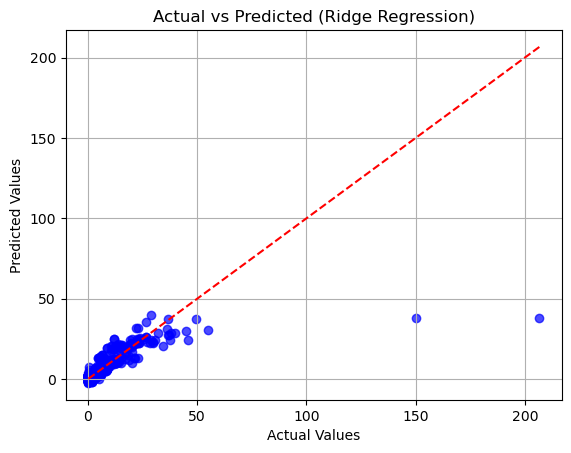

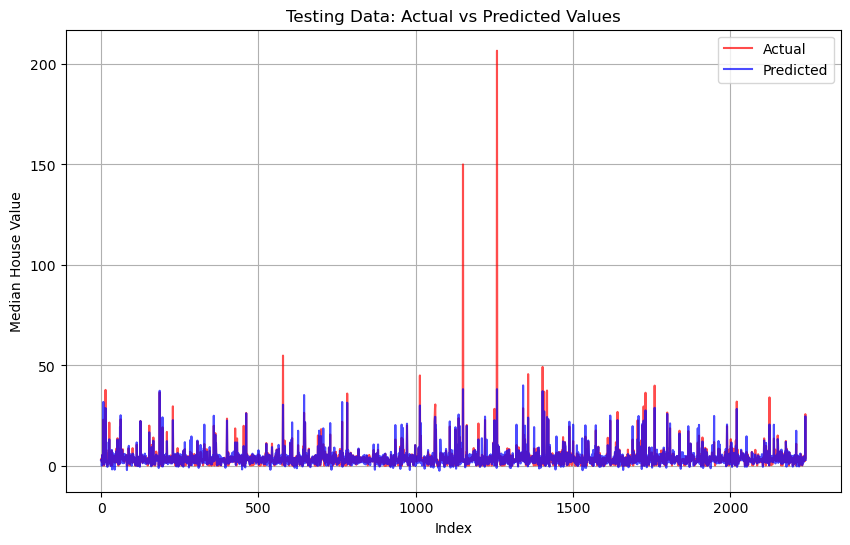

In [258]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define a pipeline with scaling and Ridge Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scale the features
    ('ridge', Ridge())             # Step 2: Apply Ridge Regression
])

# Define hyperparameter grid for alpha
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 200, 500]
}

# Use GridSearchCV for hyperparameter tuning
ridge_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Best alpha value
best_alpha = ridge_grid.best_params_['ridge__alpha']
print(f"Best Alpha: {best_alpha}")


from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test set
y_pred = ridge_grid.best_estimator_.predict(X_test)

# Calculate RMSE and R^2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted (Ridge Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set using the Ridge model
y_pred = ridge_grid.best_estimator_.predict(X_test)

# Plot: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", alpha=0.7)
plt.title("Testing Data: Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Median House Value")
plt.legend()
plt.grid()
plt.show()



## 5.2 Lasso Regression model

Best Alpha (Regularization Strength): 0.01
Root Mean Squared Error (RMSE): 4.6782
R² Score: 0.5483


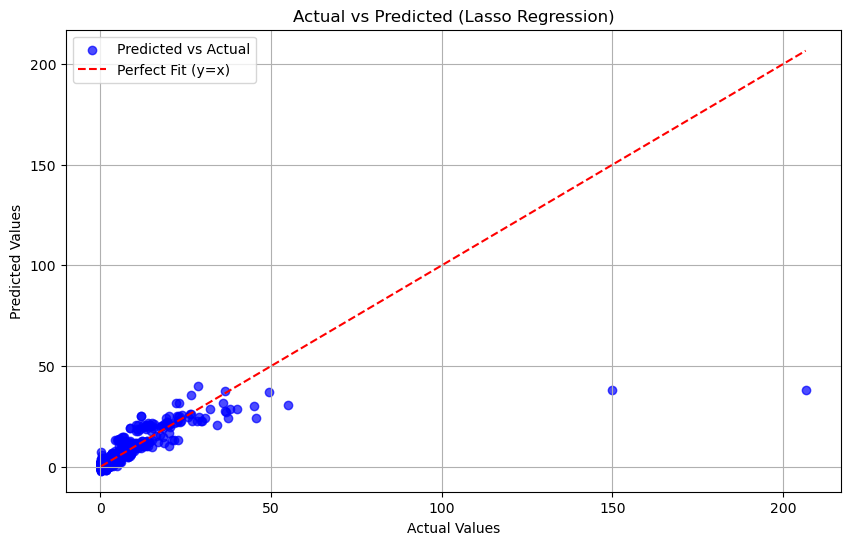

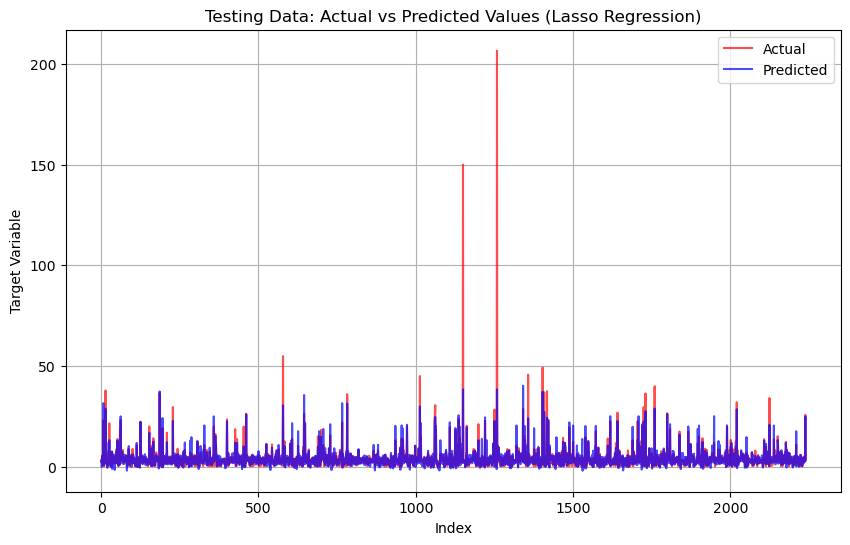

In [259]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline: scaling + Lasso Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('lasso', Lasso(max_iter=10000))  # Apply Lasso Regression
])

# Define the hyperparameter grid for alpha
param_grid = {
    'lasso__alpha': [0.01, 0.1, 1, 10, 50, 100]
}

# Set up GridSearchCV for hyperparameter tuning
lasso_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Best alpha value
best_alpha = lasso_grid.best_params_['lasso__alpha']
print(f"Best Alpha (Regularization Strength): {best_alpha}")

# Predict on the test set using the best Lasso model
y_pred = lasso_grid.best_estimator_.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Scatter plot: Actual vs Predicted for Lasso Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b', label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title('Actual vs Predicted (Lasso Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()


# Plot: Actual vs Predicted values 
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (Lasso Regression)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


## Linear models may not be complex enough to capture the relationship between the features and target.
## Consider using tree-based models like Random Forest or Gradient Boosting, which are more flexible and can handle non-linear relationships.

## 5.3 Randon Forest

In [260]:

from sklearn.ensemble import RandomForestRegressor

# Define parameter grid for GridSearchCV
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20, 30]
}

# Create a pipeline with scaling and Random Forest
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('model', RandomForestRegressor(random_state=42))  
])

# Use GridSearchCV for hyperparameter tuning
rf_grid_search = GridSearchCV(
    rf_pipeline, 
    param_grid=param_grid_rf, 
    cv=3,  
    scoring='neg_mean_squared_error',  
    verbose=1,  # Verbosity to show progress
    n_jobs=1  # Use a single core to avoid pickling issues
)

# Fit the GridSearchCV on training data
rf_grid_search.fit(X_train, y_train)

# Extract the best model
best_rf_model = rf_grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Display results
print(f"Best Parameters: {rf_grid_search.best_params_}")
print(f"Random Forest Regressor (GridSearchCV) - RMSE: {rmse_rf:.4f}, R^2 Score: {r2_rf:.4f}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'model__max_depth': 30, 'model__n_estimators': 300}
Random Forest Regressor (GridSearchCV) - RMSE: 1.7577, R^2 Score: 0.9362


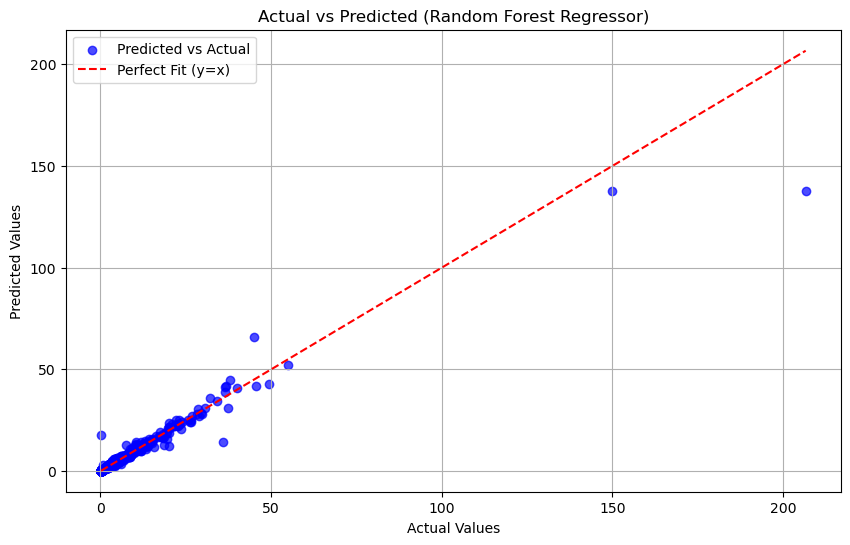

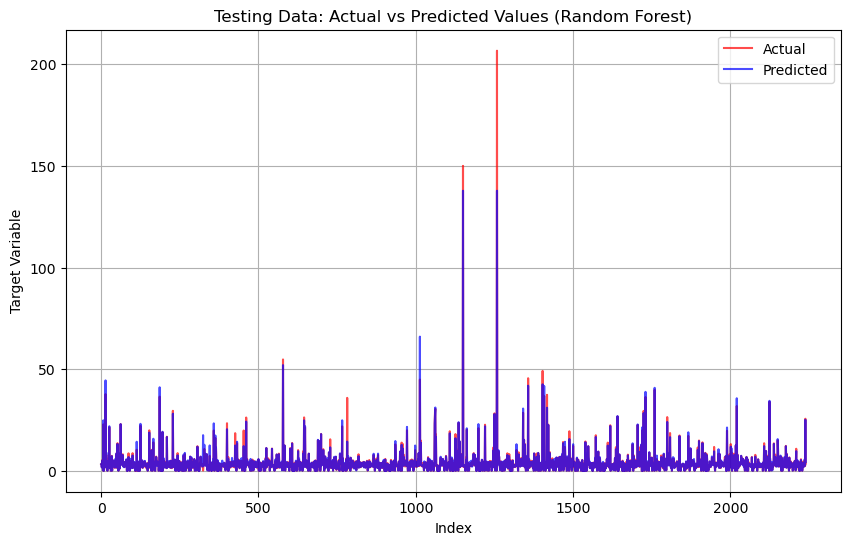

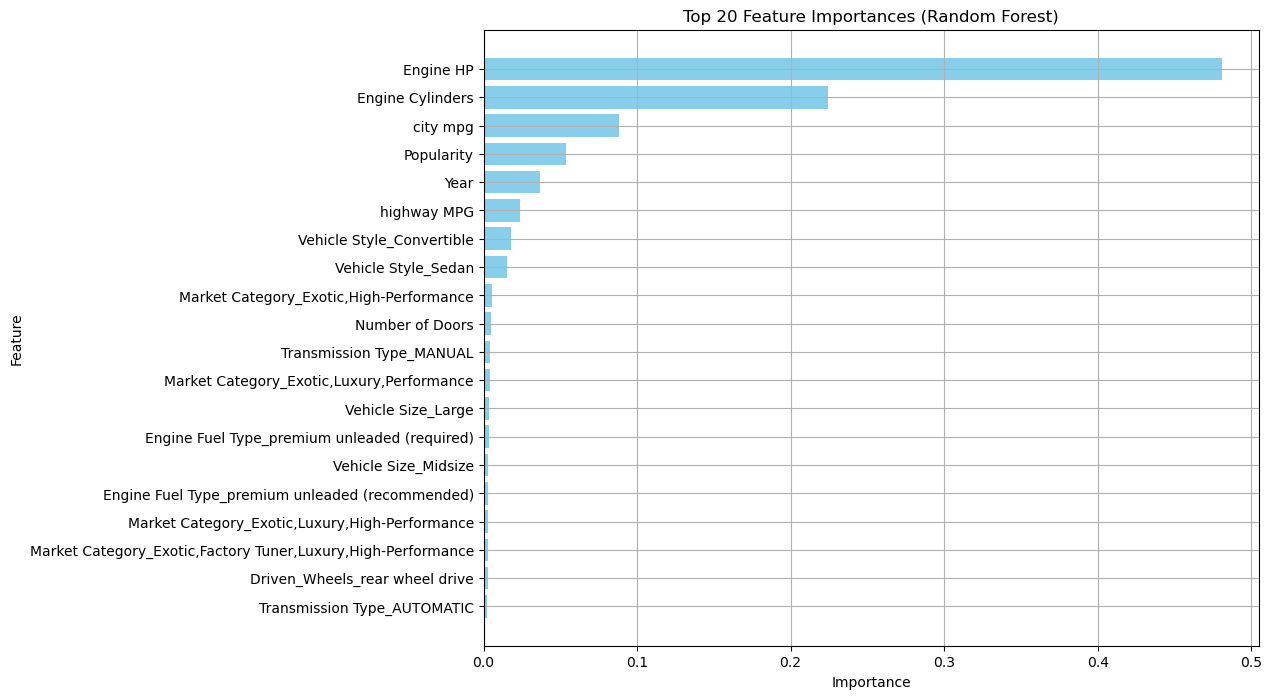

In [261]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, color="blue", label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit (y=x)")
plt.title('Actual vs Predicted (Random Forest Regressor)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Extract feature importances and sort them
feature_importances = best_rf_model.named_steps['model'].feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature {i}" for i in range(X_train.shape[1])]

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Limit to Top-N features
top_n = 20  # Display only the top 20 features
top_features = importance_df.head(top_n)

# Line Plot: Actual vs Predicted Values for Random Forest
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7, linewidth=1.5)
plt.plot(range(len(y_pred_rf)), y_pred_rf, label="Predicted", color="blue", alpha=0.7, linewidth=1.5)
plt.title("Testing Data: Actual vs Predicted Values (Random Forest)")
plt.xlabel("Index")
plt.ylabel("Target Variable")
plt.legend()
plt.grid()
plt.show()


# Bar Plot: Feature Importances
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color="skyblue")
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.grid()
plt.show()


## 5.4 Gradient Boosting Model (GBM)

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.impute import SimpleImputer


# Handle boolean columns by converting them to integers
X_train = X_train.astype({col: 'int' for col in X_train.select_dtypes(include=['bool']).columns})
X_test = X_test.astype({col: 'int' for col in X_test.select_dtypes(include=['bool']).columns})

# Check and handle missing values
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Ensure target shape is 1D
y_train = y_train.ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10]
}

# Initialize LightGBM
lgbm = LGBMRegressor(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Predict and evaluate the model
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Tuned LightGBM - RMSE: {rmse:.4f}, R²: {r2:.4f}")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 5972, number of used features: 64
[LightGBM] [Info] Start training from score 4.267921
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 541
[LightGBM] [Info] Number of data points in the train set: 5973, number of used features: 64
[LightGBM] [Info] Start training from score 4.145406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_row_wise

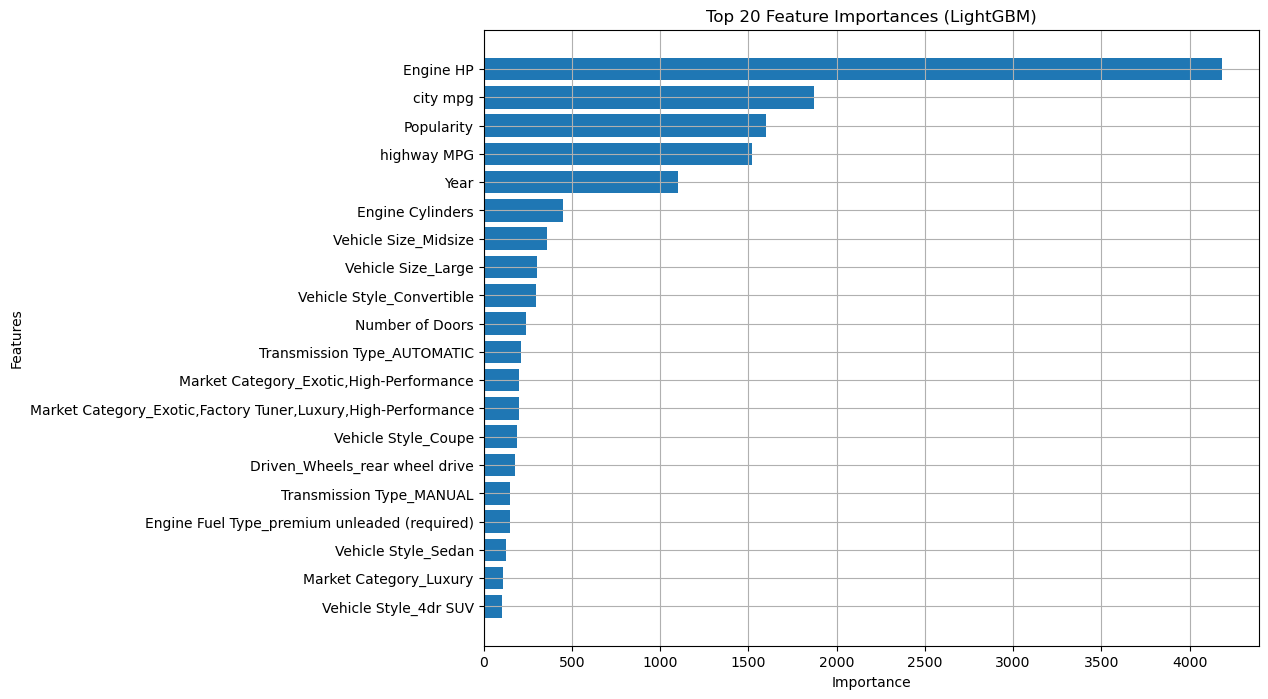

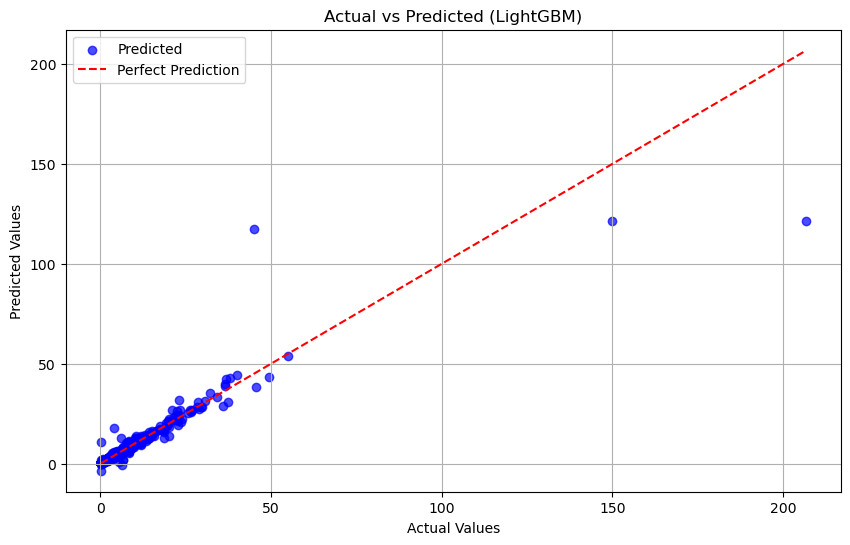

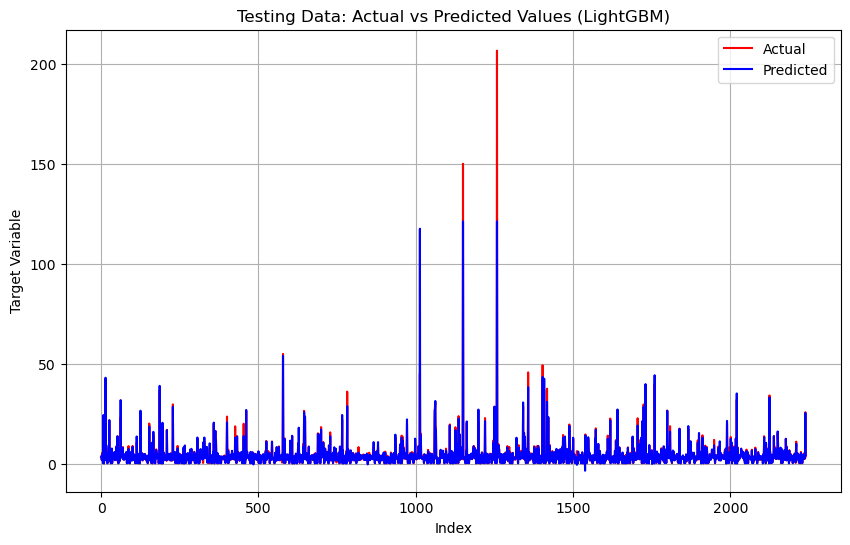

In [277]:
# plot1: Extract feature importance
feature_importances = best_model.feature_importances_
sorted_idx = np.argsort(feature_importances)[-20:]  # Top 20 features

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])  # Replace with feature names if available
plt.title('Top 20 Feature Importances (LightGBM)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.grid(True)
plt.show()

# Plot 2: Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')
plt.title('Actual vs Predicted (LightGBM)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

# Generate the Actual vs Predicted Values plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, color='red', label='Actual')  # Plot actual values
plt.plot(range(len(y_test)), y_pred, color='blue', label='Predicted')  # Plot predicted values
plt.title('Testing Data: Actual vs Predicted Values (LightGBM)')
plt.xlabel('Index')
plt.ylabel('Target Variable')
plt.legend()
plt.grid(True)
plt.show()
